# Statistics on Photometric visits in LSSTComCamSim

- Author : Sylvie Dagoret-Campagne
- creation date : 2024-04-10
- last update : 2024-05-04
- affiliation : IJCLab/IN2P3/CNRS

  
``Quantum Graphs``: https://tigress-web.princeton.edu/~lkelvin/pipelines/ 

``CalibrateTask``: 
https://github.com/lsst/pipe_tasks/blob/main/python/lsst/pipe/tasks/calibrate.py#L392-L399


``Shemas``:
https://dm.lsst.org/sdm_schemas/browser/

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm
from matplotlib.colors import ListedColormap
from matplotlib import colors
from matplotlib.ticker import FormatStrFormatter

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
from spectractor.tools import from_lambda_to_colormap, wavelength_to_rgb
#%matplotlib widget 
import h5py
from scipy import interpolate
from astropy.time import Time
from datetime import datetime, timedelta
import seaborn as sns

from itertools import cycle, islice
import os

In [2]:
from lsst.daf.butler import Butler

import astropy.units as u
import numpy as np 
import pandas as pd
pd.set_option("display.max_columns", None)
from astropy.time import Time

import scipy.stats

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

import lsst.afw.display.rgb as afwRgb
import lsst.afw.image as afwImage
import lsst.geom as geom
from lsst.geom import Angle
from lsst.geom import SpherePoint
from lsst.geom import AngleUnit

from astropy.stats import SigmaClip


In [3]:
# INSERT YOUR auxTel/LATISS collection and tract/band HERE
butlerRoot = "/repo/embargo"

collection1 = 'LSSTComCamSim/runs/nightlyvalidation/20240402/d_2024_03_29/DM-43612'
collection2 = 'LSSTComCamSim/runs/nightlyvalidation/20240403/d_2024_03_29/DM-43612'
collection3 = 'LSSTComCamSim/runs/nightlyvalidation/20240404/d_2024_03_29/DM-43612'
collectionn = collection2
#collections = [collection1,collection2,collection3]
collections = [collection2]
collectionStr = collectionn.replace("/", "_")
instrument = 'LSSTComCamSim'
skymapName = "ops_rehersal_prep_2k_v1"
where_clause = "instrument = \'" + instrument+ "\'"
NDET = 9
suptitle=  collectionStr
fn_ccdVisit_tracts_patches = f"ccdVisittractpatch_{collectionStr}.csv"

In [4]:
plt.rcParams["figure.figsize"] = (18,8)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
plt.rcParams['legend.fontsize']=  12
plt.rcParams['font.size'] = 12

In [5]:
def angle_in_range(alpha, lower, upper):
    return (alpha - lower) % 360 <= (upper - lower) % 360

In [6]:
def get_bbox_radec(wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    ramin,ramax,decmin,decmax in decimal degrees
    """

    xmin = bbox.beginX
    xmax = bbox.endX
    ymin = bbox.beginY
    ymax = bbox.endY
    
    radec_ll = wcs.pixelToSky(xmin, ymin)
    radec_ur = wcs.pixelToSky(xmax, ymax)
        
    return radec_ur.getRa().asDegrees(),radec_ll.getRa().asDegrees(), radec_ll.getDec().asDegrees(),radec_ur.getDec().asDegrees() 


In [7]:
def isradec_inbbox_angularsep(ra,dec,wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    ra: ra in degree
    dec: dec in degree
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    float in degree
    
    """

   
    RAMIN,RAMAX,DECMIN,DECMAX = get_bbox_radec(wcs, bbox)
  
    RAMEAN = np.mean([RAMIN,RAMAX])
    DECMEAN = np.mean([DECMIN,DECMAX])

    sp0 = SpherePoint(longitude=geom.Angle(ra,geom.degrees),latitude=geom.Angle(dec,geom.degrees))
    sp1 = SpherePoint(longitude=geom.Angle(RAMEAN,geom.degrees),latitude=geom.Angle(DECMEAN,geom.degrees)) 
    
    sep = sp0.separation(sp1).asDegrees()
     
    return sep

In [8]:
def isradec_inbbox_radec(ra,dec,wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    ra: ra in degree
    dec: dec in degree
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    Bool
    
    """

    RAMIN,RAMAX,DECMIN,DECMAX = get_bbox_radec(wcs, bbox)

    flag_ra = angle_in_range(ra,RAMIN,RAMAX)
    flag_dec = angle_in_range(dec,DECMIN,DECMAX)

    flag = flag_ra and flag_dec
    return flag


In [9]:
def FindTractAndPatch(row):
    """
    Apply this function on ccdvisitTable dataframe to find the tract and patch for each visit
    """
     
    try:
        ra = row["ra"]
        dec = row["dec"]
        selectFlag = False
        # loop on tract
        for tractID in tractsId_list:
            tractInfo = skymap.generateTract(tractID)
            patches_selected = [patch.getSequentialIndex() for patch in tractInfo]
            wcs=tractInfo.getWcs()
            # loop on patches
            for patch in tractInfo:
                patchID = patch.getSequentialIndex()
                if patchID in patches_selected:
                    ibb=patch.getInnerBBox()
                    flag = isradec_inbbox_radec(ra,dec,wcs, ibb)
                    selectFlag =  selectFlag or flag
                    if selectFlag:
                        return pd.Series([tractID,patchID])
        return pd.Series([0,0])           
                
    except Exception as inst:
        print(type(inst))    # the exception type
        print(inst.args)     # arguments stored in .args
        print(inst)          # __str__ allows args to be printed directly,
        return pd.Series([0,0])  
        

In [10]:
def FindTractAndPatchFromAngularSep(row):
    """
    Apply this function on ccdvisitTable dataframe to find the tract and patch for each visit
    Need the tractsId_list not to scan the whole skymap
    """

     
    try:
        ra = row["ra"]
        dec = row["dec"]
        
        # loop on tracts
        List_of_tractids = []
        List_of_patchids = []
        List_of_sep = []
        
        for tractID in tractsId_list:
            tractInfo = skymap.generateTract(tractID)
            patches_selected = [patch.getSequentialIndex() for patch in tractInfo]
         
            wcs=tractInfo.getWcs()
            # loop on patches
            patches_ids = []
            patches_sep = []
            # loop on patches
            for patch in tractInfo:
                patchID = patch.getSequentialIndex()
                if patchID in patches_selected:
                    ibb=patch.getInnerBBox()
                  
                    sep = isradec_inbbox_angularsep(ra,dec,wcs, ibb)
                    patches_ids.append(patchID)
                    patches_sep.append(sep)
                    
            # find the patch with the minimum distance
            patches_ids=np.array(patches_ids)
            patches_sep= np.array(patches_sep)
            idx_sepmin = int(np.where(patches_sep==patches_sep.min())[0])
            
            
            List_of_tractids.append(tractID)
            List_of_patchids.append(patches_ids[idx_sepmin])
            List_of_sep.append(patches_sep[idx_sepmin])
            
        List_of_tractids=np.array(List_of_tractids)
        List_of_patchids=np.array(List_of_patchids)
        List_of_sep= np.array(List_of_sep)
        idx_sepmin = int(np.where(List_of_sep==List_of_sep.min())[0])

        tractID_sel = List_of_tractids[idx_sepmin]
        patchID_sel = List_of_patchids[idx_sepmin]
       
            
        return pd.Series([tractID_sel,patchID_sel])
               
                
    except Exception as inst:
        print(type(inst))    # the exception type
        print(inst.args)     # arguments stored in .args
        print(inst)          # __str__ allows args to be printed directly,
        return pd.Series([0,0])  
        

In [11]:
def plotAVisit(row,ax=None):
    """
    row : dataframe row
    ax 
    """

    if ax == None:
        fig, ax = plt.subplots(1,1,figsize=(5,5))
        
    visitid = row["visitId"]
    ra= row["ra"]
    dec = row["dec"]
    tract_id  = row["tractID"]
    patch_id  = row["patchID"]
    label = f"tract {tract_id} , patch {patch_id}"              
    
    tractInfo = skymap.generateTract(tract_id)
    patches_selected = [patch.getSequentialIndex() for patch in tractInfo]     
    wcs=tractInfo.getWcs()
            
    # loop on patches
    all_ra = []
    all_dec = []
    corners = []
    for patch in tractInfo:
        patchID = patch.getSequentialIndex()
        if patchID == patch_id :
            ibb=patch.getInnerBBox()
            RAMIN,RAMAX,DECMIN,DECMAX = get_bbox_radec(wcs, ibb)
            for icorn,corner in enumerate(ibb.getCorners()):
                p = geom.Point2D(corner.getX(), corner.getY())
                coord = wcs.pixelToSky(p)
                corners.append([coord.getRa().asDegrees(), coord.getDec().asDegrees()])
                all_ra.append(coord.getRa().asDegrees()) 
                all_dec.append(coord.getDec().asDegrees()) 
    if (len(all_ra)>0) and (len(all_dec)>0):
        all_ra.append(all_ra[0])
        all_dec.append(all_dec[0])
        print(ax)
        ax.plot(all_ra,all_dec,'b-',lw=3,label=label)
        ax.scatter([ra],[dec],marker = 'o',s=20,c="r",label=visitid)
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax.legend()
                

## Initiate the butler

In [12]:
# Initiate butler from variables set above
butler = Butler(butlerRoot, collections=collections, instrument=instrument, skymap=skymapName)
camera = butler.get("camera", instrument=instrument)
print("camera_name = {}".format(camera.getName()))
print("collections = {}".format(collections))

camera_name = LSSTComCamSim
collections = ['LSSTComCamSim/runs/nightlyvalidation/20240403/d_2024_03_29/DM-43612']


In [13]:
skymap = butler.get('skyMap', skymap=skymapName, collections=collections)

In [14]:
datasetRefs = butler.registry.queryDatasets(datasetType='ccdVisitTable', collections=collections, where= where_clause)

## tracts and patches

In [15]:
nImage_refs = list(butler.registry.queryDatasets('deepCoadd_nImage'))

In [16]:
tractsId_list = np.unique([ref.dataId['tract'] for ref in nImage_refs])
tractsId_list = sorted(tractsId_list)
print(tractsId_list)

[2494, 2495, 2661, 2662, 3200, 3345, 3346, 3384, 3385, 3533, 3534, 6914, 6915, 7148, 7149, 7445, 7446, 7683, 7684, 9570, 9637, 9638, 9812, 9813, 9880, 9881]


## Visit Table

In [17]:
ccd_visit_table = butler.get('ccdVisitTable', dataId={'instrument': instrument}, collections = collections )    

### shorted visitid

In [18]:
ccd_visit_table["ccdVid"] = ccd_visit_table.index -  ccd_visit_table.index[0]
ccd_visit_table["Vid"] = ccd_visit_table["visitId"]  -   ccd_visit_table["visitId"].iloc[0]

### Get nightObs, Time-datetime, airmass

In [19]:
#subtract the a bug number to have normal dates
ccd_visit_table["nightObs"] = ccd_visit_table.apply(lambda x: x['visitId']//100_000 - 50000000, axis=1)
ccd_visit_table["nightObs"]

ccdVisitId
730865860864    20240403
730865860865    20240403
730865860866    20240403
730865860867    20240403
730865860868    20240403
                  ...   
730866060292    20240403
730866060293    20240403
730866060294    20240403
730866060295    20240403
730866060296    20240403
Name: nightObs, Length: 6301, dtype: int64

In [20]:
#  get time
ccd_visit_table["Time"] = pd.to_datetime(ccd_visit_table['obsStart'])

In [21]:
# get airmass
ccd_visit_table["airmass"] = ccd_visit_table["zenithDistance"].apply(lambda x: 1/np.cos(np.pi/180.*x))

In [22]:
#ccd_visit_table_subset = ccd_visit_table[["ra","dec"]].iloc[:10]
#ccd_visit_table_subset[["tractID","patchID"]] =  ccd_visit_table_subset.apply( FindTractAndPatch, axis=1,result_type ='expand')

In [23]:
# to speed up the calculation of tractID, patchID per visit, this file is saved
# or read back
if os.path.isfile(fn_ccdVisit_tracts_patches):
    print(f"{fn_ccdVisit_tracts_patches} found !!! ==> Read it !!!" )
    ccd_visit_tract_patch_table = pd.read_csv(fn_ccdVisit_tracts_patches) 
    ccd_visit_tract_patch_table.set_index("ccdVisitId",inplace=True)
    ccd_visit_tract_patch_table_only = ccd_visit_tract_patch_table[["tractID","patchID"]]
    ccd_visit_table = ccd_visit_table.join(ccd_visit_tract_patch_table_only)
else:
    print(f"{fn_ccdVisit_tracts_patches} NOT found !!! ==> Create it !!! " )
    ccd_visit_table[["tractID","patchID"]] = ccd_visit_table.apply(FindTractAndPatch, axis=1,result_type ='expand')
    # check if some (tract,patch) search failed
    ccd_visit_table_patchnotfound = ccd_visit_table[ccd_visit_table.patchID==0]
    if len(ccd_visit_table_patchnotfound)>0:
        ccd_visit_table_patchnotfound.drop(columns=["tractID","patchID"],inplace=True)
        ccd_visit_table_patchnotfound[["tractID","patchID"]] = ccd_visit_table_patchnotfound.apply(FindTractAndPatchFromAngularSep, axis=1,result_type ='expand')
        for visitindex, row in ccd_visit_table_patchnotfound.iterrows(): 
            ccd_visit_table.loc[visitindex,["tractID","patchID"]] = ccd_visit_table_patchnotfound.loc[visitindex,["tractID","patchID"]]
    #save a subsample for the visit 
    columns_selected = ["visitId","band","detector","ra","dec","llcra","llcdec","ulcra","ulcdec","urcra","urcdec","lrcra","lrcdec","ccdVid","Vid","nightObs","tractID","patchID","zeroPoint","airmass","skyBg","skyNoise","expTime"]
    ccd_visit_tract_patch_table = ccd_visit_table[columns_selected]
    ccd_visit_tract_patch_table.to_csv(fn_ccdVisit_tracts_patches) 

ccdVisittractpatch_LSSTComCamSim_runs_nightlyvalidation_20240403_d_2024_03_29_DM-43612.csv NOT found !!! ==> Create it !!! 


/tmp/ipykernel_29582/1175591681.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccd_visit_table_patchnotfound.drop(columns=["tractID","patchID"],inplace=True)
/tmp/ipykernel_29582/1175591681.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccd_visit_table_patchnotfound[["tractID","patchID"]] = ccd_visit_table_patchnotfound.apply(FindTractAndPatchFromAngularSep, axis=1,result_type ='expand')
/tmp/ipykernel_29582/1175591681.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [24]:
#ccd_visit_table[["tractID","patchID"]] = ccd_visit_table.apply( FindTractAndPatch, axis=1,result_type ='expand')

In [25]:
ccd_visit_table

,visitId,physical_filter,band,ra,dec,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,ccdVid,Vid,nightObs,Time,airmass,tractID,patchID
ccdVisitId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
730865860864,7024040300001,r_03,r,124.617999,-15.026212,17.825243,31.258871,1.507056,1703.767822,34.471790,0.005423,0.003085,534,0.000671,0.000063,0.010385,0.010232,-0.001001,0.009205,0.006108,0.012708,343.330109,11.789084,1.127149,0.344765,1.011240,-15.026212,0,0.711160,121.461718,2024-04-03 23:30:29.555496,60403.979509,30.0,2024-04-03 23:30:14.555496,60403.979335,33.0576,4071,3999,124.458471,-15.063877,124.581823,-14.871498,124.777487,-14.988434,124.654231,-15.180921,0,0,20240403,2024-04-03 23:30:14.555496,1.050426,6914,246
730865860865,7024040300001,r_03,r,124.745824,-14.826505,18.059967,31.238535,1.508598,1674.763306,32.659889,0.004810,0.002649,521,-0.000758,0.000405,0.010847,0.010906,-0.000540,0.010071,0.006677,0.011858,327.926941,11.528691,1.124846,0.350736,0.974059,-14.826505,1,0.710764,121.461718,2024-04-03 23:30:29.555496,60403.979509,30.0,2024-04-03 23:30:14.555496,60403.979335,33.0576,4071,3999,124.586453,-14.864268,124.709592,-14.671812,124.905148,-14.788632,124.782113,-14.981198,1,0,20240403,2024-04-03 23:30:14.555496,1.051820,7149,12
730865860866,7024040300001,r_03,r,124.873418,-14.626731,18.294695,31.259706,1.525470,1709.555664,33.396534,0.004649,0.002711,499,-0.000471,-0.000007,0.010723,0.010910,0.000434,0.009015,0.005919,0.015276,507.804199,11.484890,1.100101,0.343598,1.012796,-14.626731,2,0.718461,121.461718,2024-04-03 23:30:29.555496,60403.979509,30.0,2024-04-03 23:30:14.555496,60403.979335,33.0576,4071,3999,124.714213,-14.664580,124.837124,-14.472080,125.032570,-14.588777,124.909767,-14.781395,2,0,20240403,2024-04-03 23:30:14.555496,1.053236,7149,61
730865860867,7024040300001,r_03,r,124.824851,-15.149693,17.819584,31.267454,1.514115,1717.083984,34.223988,0.004732,0.002868,504,-0.000470,-0.000685,0.009737,0.010434,-0.000375,0.010328,0.006824,0.019305,371.574188,11.773538,1.116663,0.342092,1.027357,-15.149693,3,0.713278,121.461718,2024-04-03 23:30:29.555496,60403.979509,30.0,2024-04-03 23:30:14.555496,60403.979335,33.0576,4071,3999,124.665250,-15.187500,124.788499,-14.995008,124.984403,-15.111770,124.861257,-15.304366,3,0,20240403,2024-04-03 23:30:14.555496,1.050393,6914,227
730865860868,7024040300001,r_03,r,124.952564,-14.949870,18.054384,31.265049,1.510671,1714.527710,33.346077,0.004954,0.002795,472,0.000277,0.000023,0.009188,0.009661,0.000165,0.010904,0.007214,0.009335,364.833038,11.792562,1.121760,0.342602,1.022816,-14.949870,4,0.711782,121.461718,2024-04-03 23:30:29.555496,60403.979509,30.0,2024-04-03 23:30:14.555496,60403.979335,33.0576,4071,3999,124.793126,-14.987773,124.916155,-14.795198,125.111945,-14.911856,124.989026,-15.104533,4,0,20240403,2024-04-03 23:30:14.555496,1.051787,6914,259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730866060292,7024040300780,r_03,r,299.857944,-40.858541,19.874241,31.276102,1.663994,1544.489258,31.839106,0.006128,0.003535,742,0.000638,-0.000605,0.012558,0.010842,-0.000502,0.011414,0.006865,0.012346,238.200607,11.011467,0.924563,0.380320,1.043851,-40.858541,4,0.784160,133.834081,2024-04-04 10:27:54.199510,60404.436044,30.0,2024-04-04 10:27:39.199510,60404.435870,33.0575,4071,3999,299.648263,-40.863270,299.855183,-40.699906,300.067595,-40.853432,2

Axes(0.125,0.11;0.775x0.77)


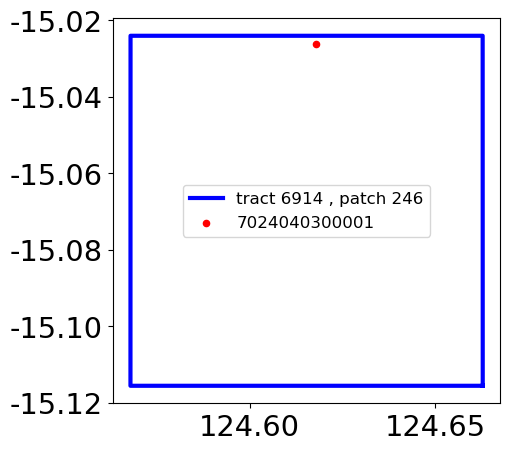

In [26]:
plotAVisit(ccd_visit_table.iloc[0])

## Statistic per detector and per band

In [27]:
ser_ccdvisit_perdetectorband_size = ccd_visit_table.groupby(["detector","band"]).size()

In [28]:
ser_ccdvisit_perdetectorband_size

detector  band
0         g       225
          i       235
          r       242
1         g       222
          i       235
          r       240
2         g       225
          i       236
          r       240
3         g       223
          i       234
          r       241
4         g       224
          i       238
          r       244
5         g       225
          i       234
          r       243
6         g       224
          i       231
          r       243
7         g       223
          i       237
          r       241
8         g       224
          i       234
          r       238
dtype: int64

In [29]:
df_ccdvisit_perdetectorband = ser_ccdvisit_perdetectorband_size.unstack(level=1)
df_ccdvisit_perdetectorband 

band,g,i,r
detector,,,
0,225,235,242
1,222,235,240
2,225,236,240
3,223,234,241
4,224,238,244
5,225,234,243
6,224,231,243
7,223,237,241
8,224,234,238


In [30]:
my_colors = list(islice(cycle(['g', 'r', 'orange']), None, len(df_ccdvisit_perdetectorband)))

<Axes: title={'center': 'Number of ccdvisits per detector and per filter'}, xlabel='detector'>

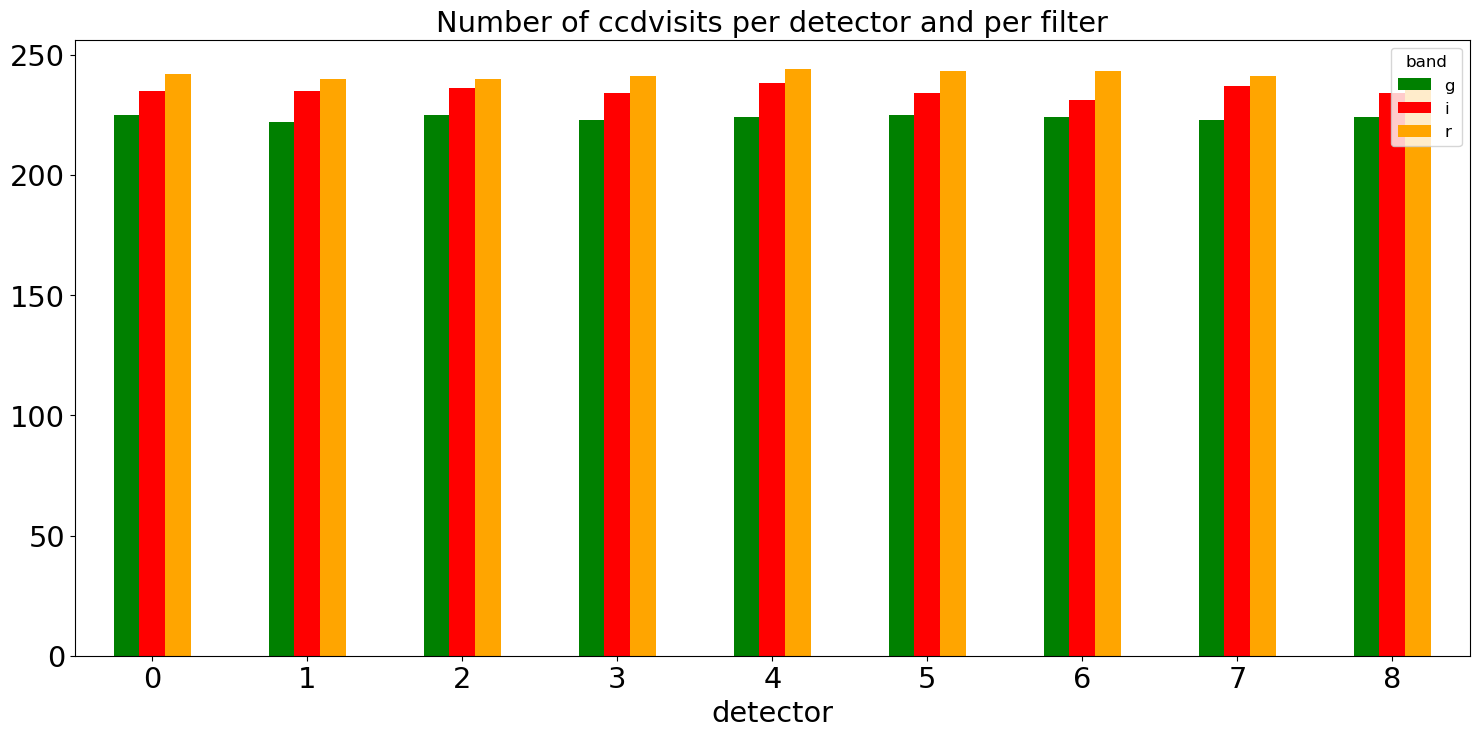

In [31]:
df_ccdvisit_perdetectorband.plot.bar(color=my_colors,rot=0,title="Number of ccdvisits per detector and per filter") 

In [32]:
cmap = ListedColormap(sns.color_palette("hls", NDET))
all_det_colors = [cmap.colors[idx] for idx in range(NDET)]

In [33]:
df_ccdvisit_perdetectorband = ser_ccdvisit_perdetectorband_size.unstack(level=0)
df_ccdvisit_perdetectorband 

detector,0,1,2,3,4,5,6,7,8
band,,,,,,,,,
g,225,222,225,223,224,225,224,223,224
i,235,235,236,234,238,234,231,237,234
r,242,240,240,241,244,243,243,241,238


<Axes: title={'center': 'Number of CCDvisits per detector and per filter'}, xlabel='band'>

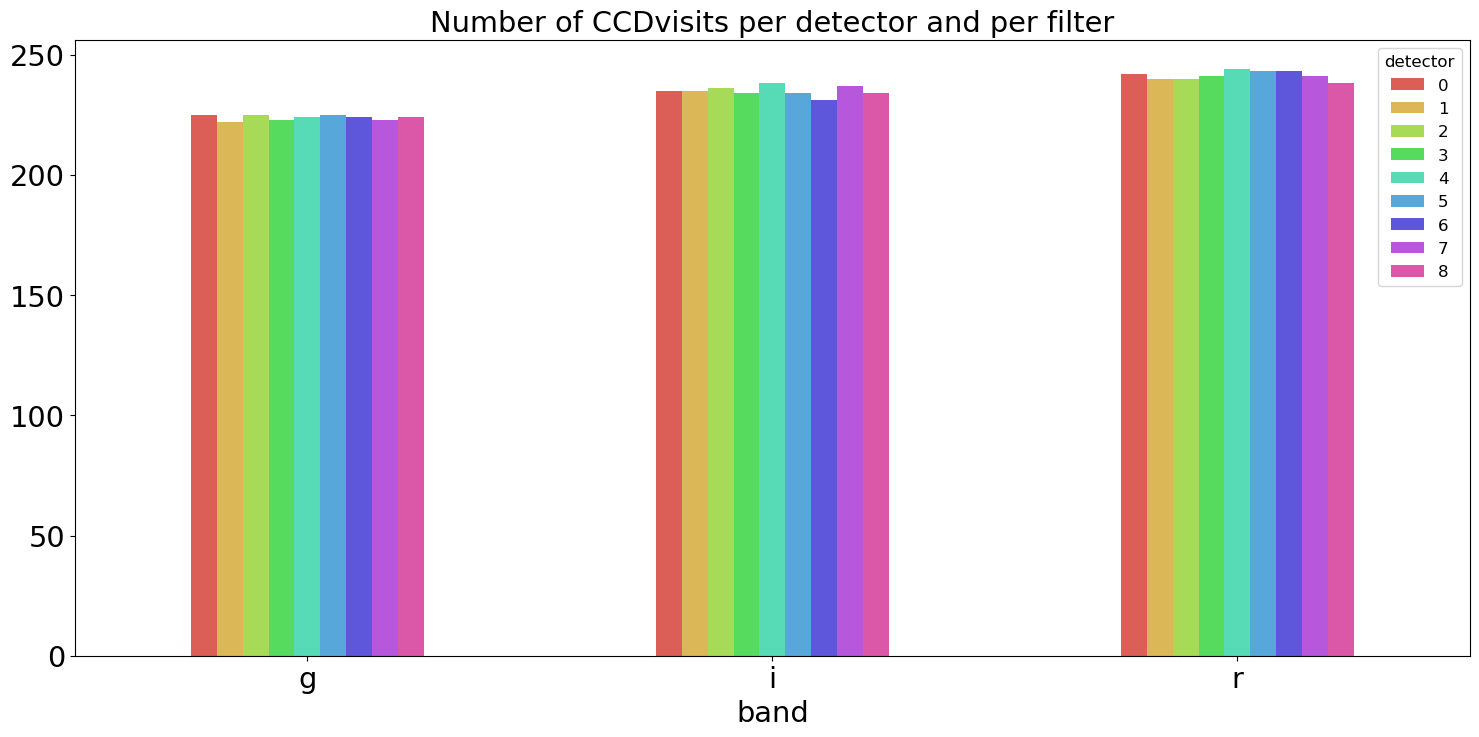

In [34]:
df_ccdvisit_perdetectorband.plot.bar(color=all_det_colors + all_det_colors + all_det_colors,rot=0,title="Number of CCDvisits per detector and per filter") 

<Axes: title={'center': 'Number of ccdvisits per detector and per filter'}, xlabel='detector,band'>

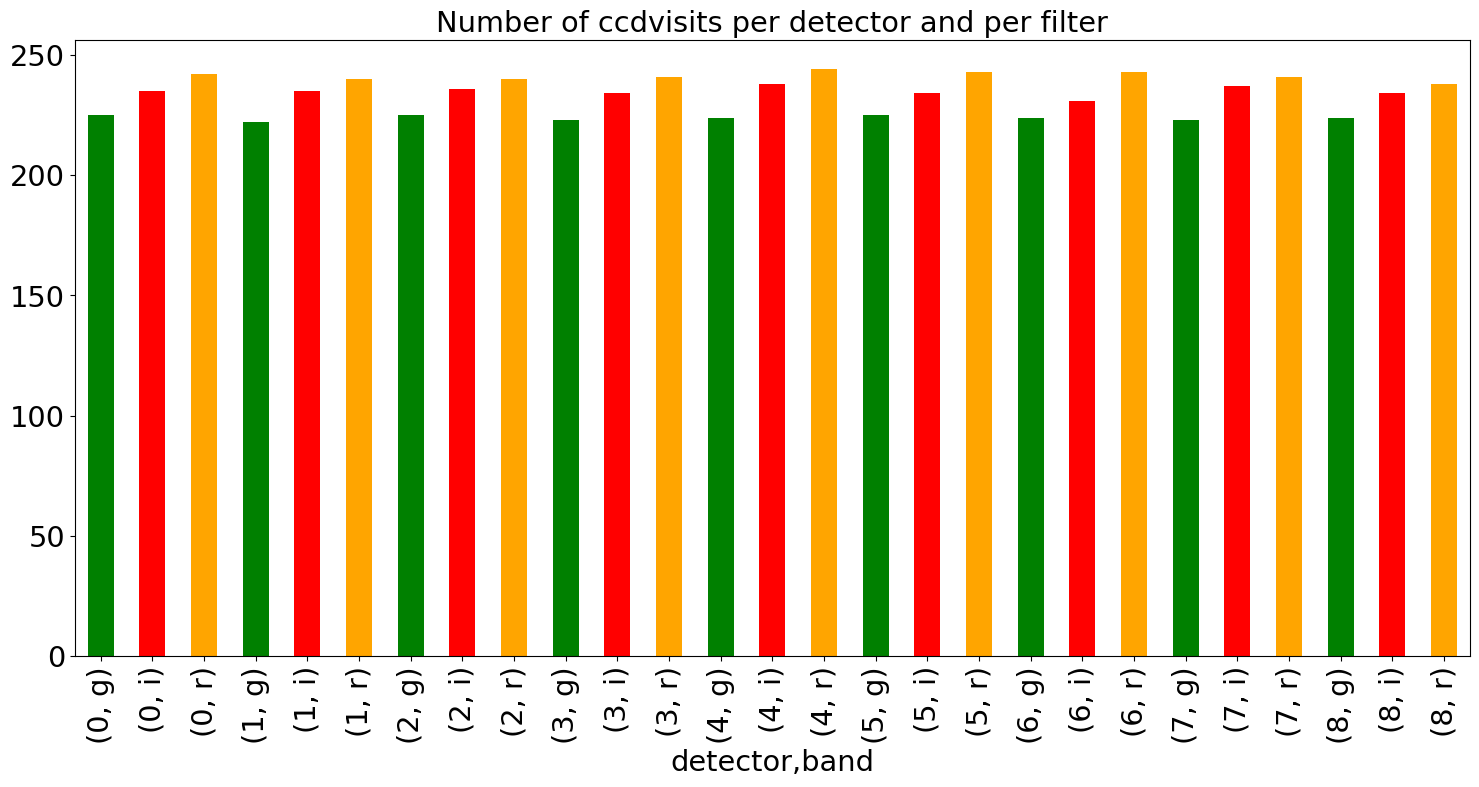

In [35]:
my_colors = list(islice(cycle(['g', 'r', 'orange']), None, NDET))
ser_ccdvisit_perdetectorband_size.plot.bar(x="detector",color=my_colors,title="Number of ccdvisits per detector and per filter")

## Visits

In [36]:
ser_tract_det_size = ccd_visit_table[["Vid","ccdVid","detector","tractID","patchID"]].groupby(["tractID","detector"]).size()

In [37]:
ser_tract_det_size

tractID  detector
2494     0            81
         1            41
         2             5
         3            96
         4            32
                    ... 
9880     4           116
         5           116
         6           111
         7           116
         8           116
Length: 101, dtype: int64

In [38]:
df_ccdvisit_pertractdet = ser_tract_det_size.unstack(level=1)

In [39]:
df_ccdvisit_pertractdet

detector,0,1,2,3,4,5,6,7,8
tractID,,,,,,,,,
2494,81.0,41.0,5.0,96.0,32.0,NaN,85.0,34.0,2.0
2495,19.0,60.0,88.0,5.0,69.0,101.0,16.0,67.0,99.0
2662,1.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN
3345,12.0,NaN,NaN,16.0,NaN,NaN,50.0,8.0,NaN
3346,NaN,1.0,NaN,10.0,10.0,17.0,34.0,69.0,74.0
3384,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0
3533,105.0,114.0,115.0,90.0,107.0,99.0,30.0,38.0,40.0
6914,104.0,95.0,69.0,97.0,95.0,45.0,76.0,61.0,25.0
6915,1.0,NaN,NaN,1.0,NaN,NaN,9.0,2.0,1.0


<Axes: title={'center': 'Number of ccdvisits per patch per detector'}, xlabel='tractID'>

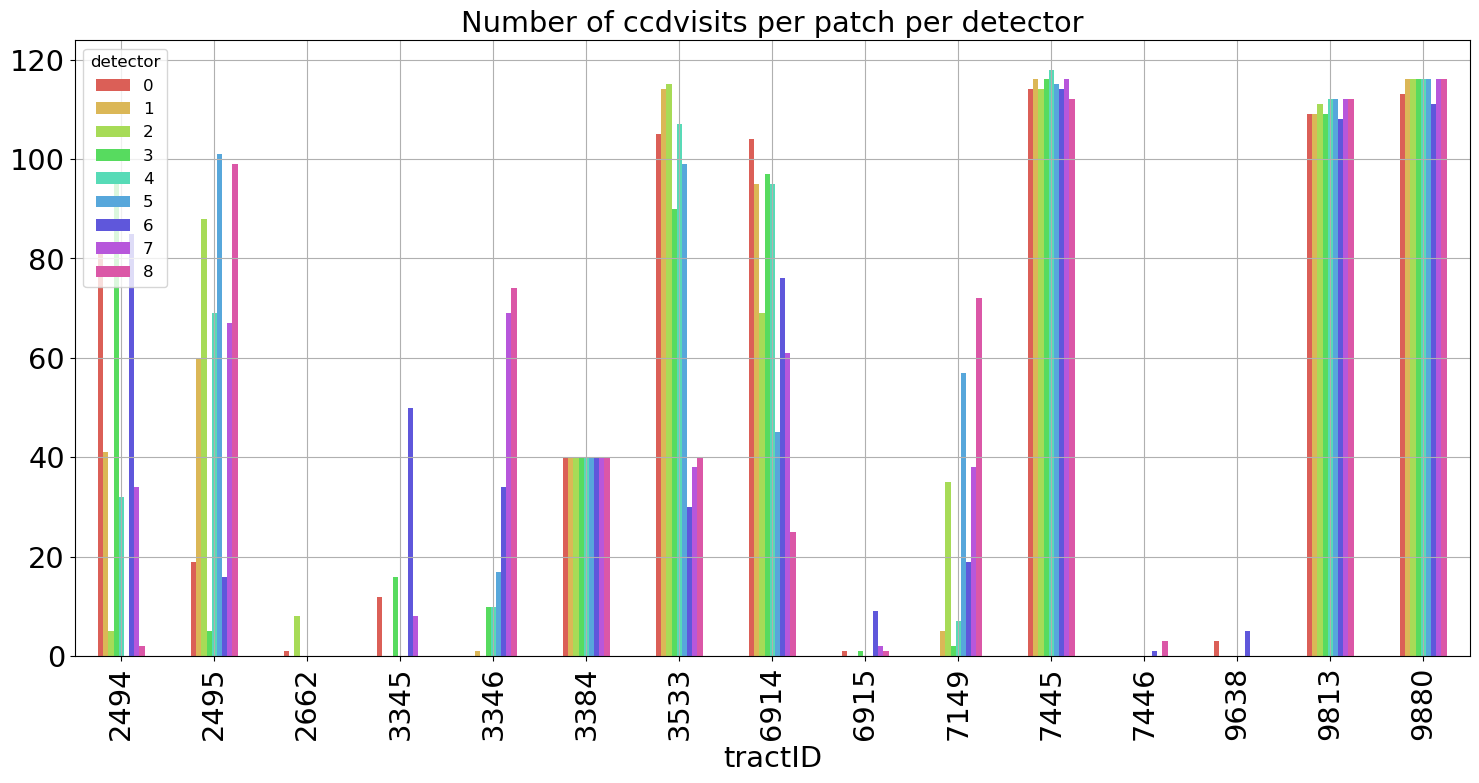

In [40]:
df_ccdvisit_pertractdet.plot.bar(color=all_det_colors,title="Number of ccdvisits per patch per detector",grid=True) 

## Understanding Vid and tractId

In [41]:
List_OfTracts = df_ccdvisit_pertractdet.index
NTracts = len(List_OfTracts)-1
NTracts

14

In [42]:
cmap = ListedColormap(sns.color_palette("hls", NTracts))
list_tracts_colors = [cmap.colors[idx] for idx in range(NTracts)]

In [43]:
list_tracts_colors = [ colors.to_rgb('k') ] + list_tracts_colors

In [44]:
len(list_tracts_colors)

15

In [45]:
dict_tract_colors = {}
for idx,itr in enumerate(List_OfTracts):
    dict_tract_colors[itr] = list_tracts_colors[idx]
    

In [46]:
all_colors = [ dict_tract_colors[itr] for itr in ccd_visit_table["tractID"].values]

<Axes: title={'center': 'tractID vs visit sequence number'}, xlabel='Vid', ylabel='tractID'>

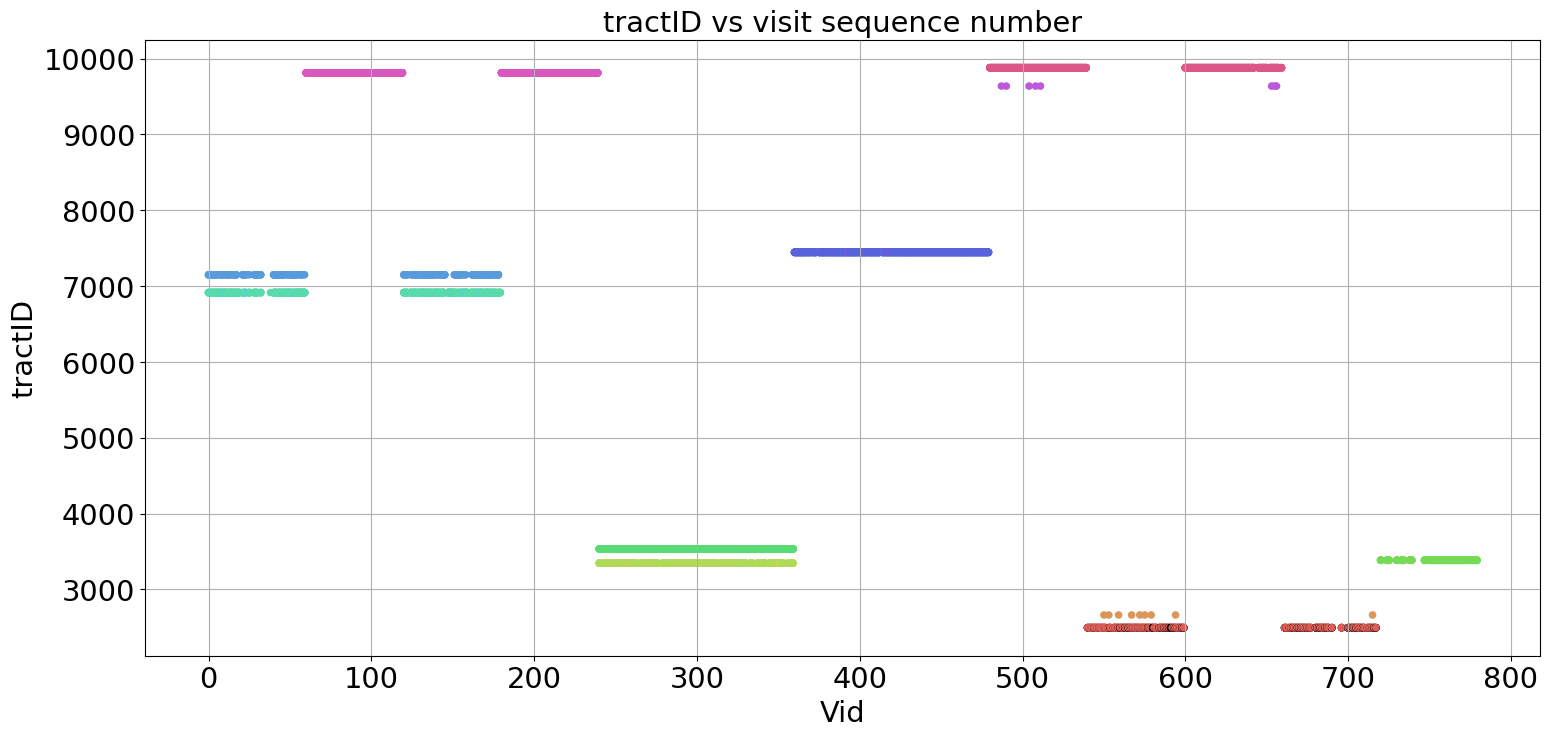

In [47]:
ccd_visit_table.plot.scatter(y="tractID",x ="Vid",marker='o',color=all_colors,title="tractID vs visit sequence number",grid=True)

In [48]:
List_OfTracts

Int64Index([2494, 2495, 2662, 3345, 3346, 3384, 3533, 6914, 6915, 7149, 7445,
            7446, 9638, 9813, 9880],
           dtype='int64', name='tractID')

## simple visit table

In [49]:
visit_table = butler.get('visitTable', dataId={'instrument': instrument}, collections = collections )    
visit_table

,visit,physical_filter,band,ra,dec,decl,skyRotation,azimuth,altitude,zenithDistance,airmass,expTime,expMidpt,expMidptMJD,obsStart,obsStartMJD
visitId,,,,,,,,,,,,,,,,
7024040300001,7024040300001,r_03,r,124.952559,-14.949878,-14.949878,121.461718,35.491938,71.834271,18.165729,1.053151,30.0,2024-04-03 23:30:29.555496,60403.979509,2024-04-03 23:30:14.555496,60403.979335
7024040300002,7024040300002,r_03,r,124.951436,-15.100181,-15.100181,120.374849,35.272148,72.051278,17.948722,1.051239,30.0,2024-04-03 23:31:11.531491,60403.979995,2024-04-03 23:30:56.531491,60403.979821
7024040300003,7024040300003,r_03,r,124.879501,-14.930244,-14.930244,118.613777,34.330998,72.025829,17.974171,1.051485,30.0,2024-04-03 23:31:53.026497,60403.980475,2024-04-03 23:31:38.026497,60403.980301
7024040300004,7024040300004,r_03,r,124.908570,-14.963176,-14.963176,117.403385,33.995775,72.123915,17.876085,1.050985,30.0,2024-04-03 23:32:34.286506,60403.980952,2024-04-03 23:32:19.286506,60403.980779
7024040300005,7024040300005,r_03,r,124.794880,-14.977465,-14.977465,115.827267,33.231582,72.273284,17.726716,1.050191,30.0,2024-04-03 23:33:15.695995,60403.981432,2024-04-03 23:33:00.695995,60403.981258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7024040300776,7024040300776,r_03,r,299.899487,-41.082086,-41.082086,137.613459,127.405108,69.374551,20.625449,1.105687,30.0,2024-04-04 10:25:08.351501,60404.434124,2024-04-04 10:24:53.351501,60404.433951
7024040300777,7024040300777,r_03,r,300.148720,-41.064252,-41.064252,136.462356,127.290776,69.330282,20.669718,1.106335,30.0,2024-04-04 10:25:49.848998,60404.434605,2024-04-04 10:25:34.848998,60404.434431
7024040300778,7024040300778,r_03,r,300.113140,-40.822769,-40.822769,135.169026,126.849875,69.574319,20.425681,1.104543,30.0,2024-04-04 10:26:31.413499,60404.435086,2024-04-04 10:26:16.413499,60404.434912


## Find Tracts involved for each date

In [50]:
df = ccd_visit_table

In [51]:
df_stat_pertract = df.groupby(by=["nightObs","tractID"]).count()["visitId"]
df_stat_pertract

nightObs  tractID
20240403  2494        376
          2495        524
          2662          9
          3345         86
          3346        215
          3384        360
          3533        738
          6914        667
          6915         14
          7149        235
          7445       1035
          7446          4
          9638          8
          9813        994
          9880       1036
Name: visitId, dtype: int64

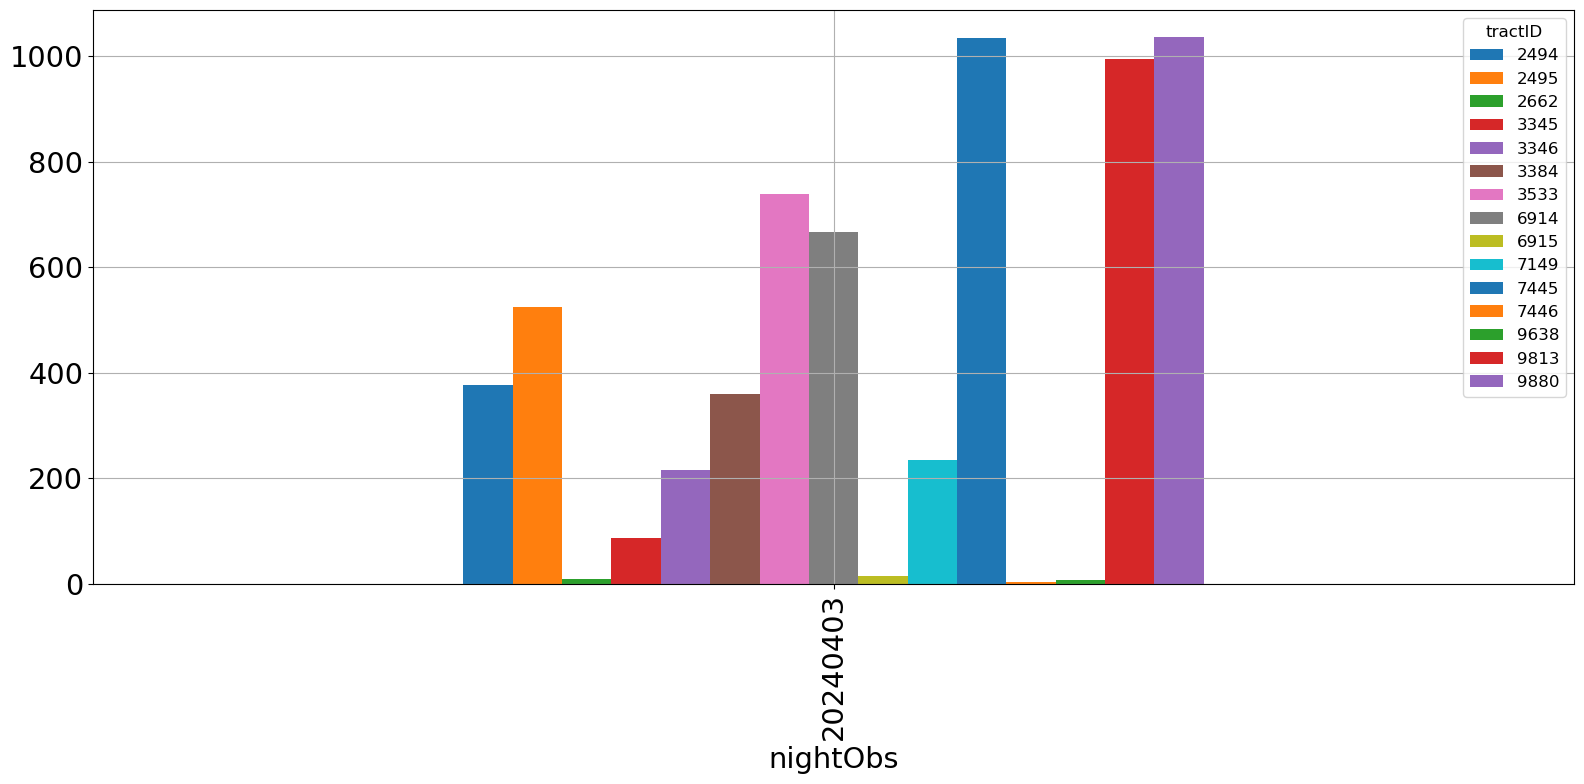

In [52]:
ax = df_stat_pertract.unstack(level=1).plot(kind='bar', subplots=False, rot=90,figsize=(16,8),grid=True)
plt.tight_layout()

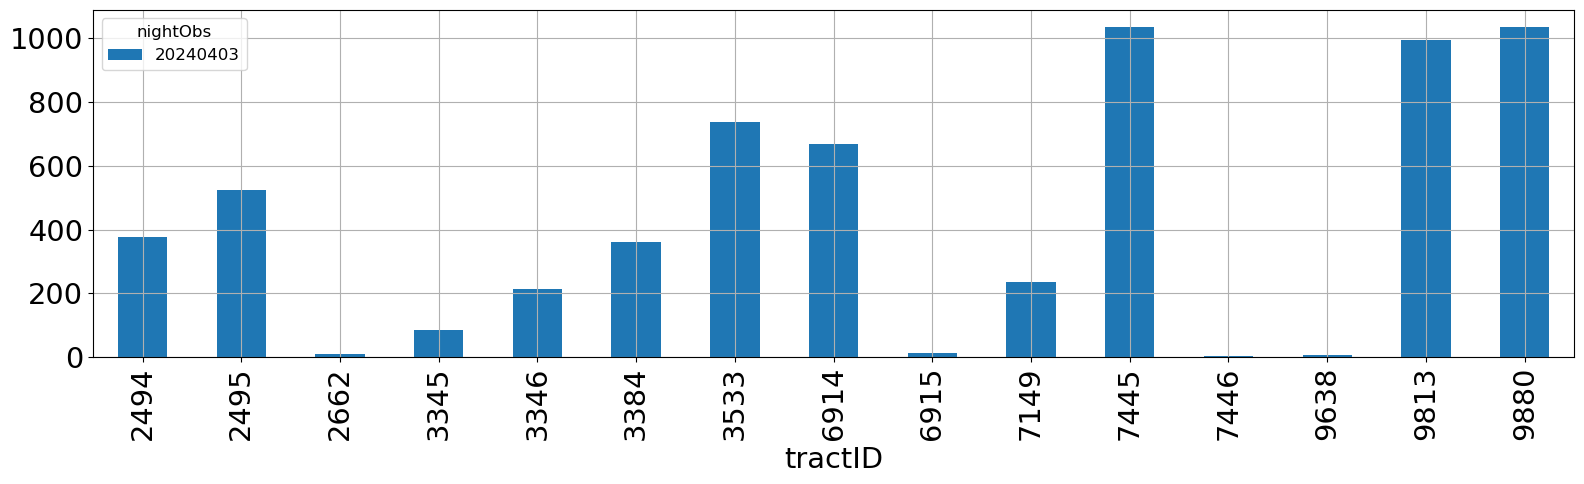

In [53]:
ax = df_stat_pertract.unstack(level=0).plot(kind='bar', subplots=False, rot=90,figsize=(16,5),grid=True)
plt.tight_layout()

## Pandas series

In [54]:
ccd_visit_table_counts = df.groupby(['nightObs','band']).count()["visitId"]
ccd_visit_table_counts_g = df[df["band"] == "g"].groupby(['nightObs']).count()["visitId"]
ccd_visit_table_counts_r = df[df["band"] == "r"].groupby(['nightObs']).count()["visitId"]
ccd_visit_table_counts_i = df[df["band"] == "i"].groupby(['nightObs']).count()["visitId"]
ccd_visit_table_counts_z = df[df["band"] == "z"].groupby(['nightObs']).count()["visitId"]
ccd_visit_table_counts_y = df[df["band"] == "y"].groupby(['nightObs']).count()["visitId"]

In [55]:
print(ccd_visit_table_counts)

nightObs  band
20240403  g       2015
          i       2114
          r       2172
Name: visitId, dtype: int64


### Observation date-time

In [56]:
def convertNumToDatestr(num):
    year = num//10_000
    month= (num-year*10_000)//100
    day = (num-year*10_000-month*100)

    year_str = str(year).zfill(4)
    month_str = str(month).zfill(2)
    day_str = str(day).zfill(2)
    
    datestr = f"{year_str}-{month_str}-{day_str}"
    return pd.to_datetime(datestr)

In [57]:
[convertNumToDatestr(num) for num in ccd_visit_table_counts_g.index ]

[Timestamp('2024-04-03 00:00:00')]

In [58]:
dt_g = pd.to_datetime([convertNumToDatestr(num) for num in ccd_visit_table_counts_g.index])
dt_r = pd.to_datetime([convertNumToDatestr(num) for num in ccd_visit_table_counts_r.index ])
dt_i = pd.to_datetime([convertNumToDatestr(num) for num in ccd_visit_table_counts_i.index ])
dt_z = pd.to_datetime([convertNumToDatestr(num) for num in ccd_visit_table_counts_z.index ])
dt_y = pd.to_datetime([convertNumToDatestr(num) for num in ccd_visit_table_counts_y.index ])

### observation counts

In [59]:
n_g = ccd_visit_table_counts_g.values
n_r = ccd_visit_table_counts_r.values
n_i = ccd_visit_table_counts_i.values
n_z = ccd_visit_table_counts_z.values
n_y = ccd_visit_table_counts_y.values

In [60]:
n_g_tot = np.sum(n_g)
n_r_tot = np.sum(n_r)
n_i_tot = np.sum(n_i)
n_z_tot = np.sum(n_z)
n_y_tot = np.sum(n_y)

n_g_min = np.min(n_g)
n_r_min = np.min(n_r)
n_i_min = np.min(n_i)
#n_z_min = np.min(n_z)
#n_y_min = np.min(n_y)

n_g_max = np.max(n_g)
n_r_max = np.max(n_r)
n_i_max = np.max(n_i)
#n_z_max = np.max(n_z)
#n_y_max = np.max(n_y)

### Observation count sum

In [61]:
s_g = n_g.cumsum()
s_r = n_r.cumsum()
s_i = n_i.cumsum()
s_z = n_z.cumsum()
s_y = n_y.cumsum()

## Plot

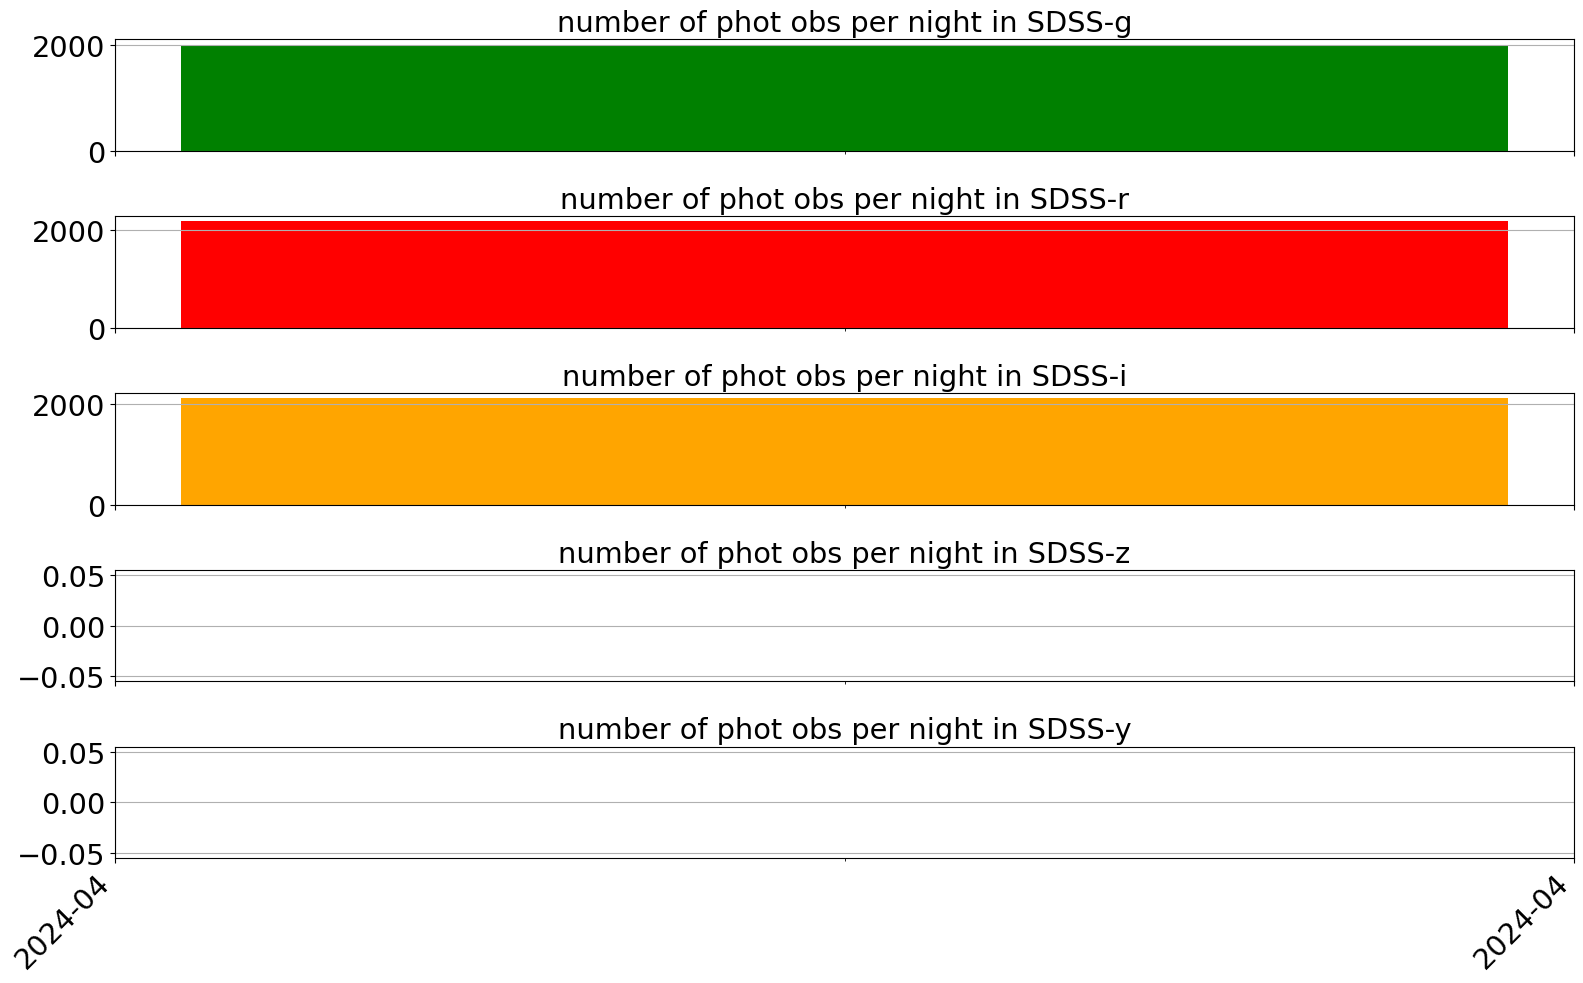

In [62]:
import matplotlib.dates as mdates
month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 
fig, axs = plt.subplots(5,1,figsize=(16, 10),sharex=True)

ax1,ax2,ax3,ax4,ax5 = axs

# fit 1
#ax.plot(dt,df_spec_visit.values,marker='o', markersize=15,lw=0)
ax1.bar(dt_g,n_g,lw=5,facecolor='g')
ax1.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax1.xaxis.set_minor_locator(day_locator)
ax1.xaxis.set_major_formatter(year_month_formatter)
ax1.grid()

title1 = f"number of phot obs per night in SDSS-g"
ax1.set_title(title1)

#fig.autofmt_xdate() # rotation
ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=45, ha='right')

#ax2.bar(dt,df_spec_visit.cumsum().values,lw=5,facecolor='b')
ax2.bar(dt_r,n_r,lw=5,facecolor='r')
ax2.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax2.xaxis.set_minor_locator(day_locator)
ax2.xaxis.set_major_formatter(year_month_formatter)
ax2.grid()

#fig.autofmt_xdate() # rotation
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=45, ha='right')
title2 = f"number of phot obs per night in SDSS-r"
ax2.set_title(title2)

#ax2.bar(dt,df_spec_visit.cumsum().values,lw=5,facecolor='b')
ax3.bar(dt_i,n_i,lw=5,facecolor='orange')
ax3.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax3.xaxis.set_minor_locator(day_locator)
ax3.xaxis.set_major_formatter(year_month_formatter)
ax3.grid()

#fig.autofmt_xdate() # rotation
ax3.set_xticks(ax3.get_xticks(), ax3.get_xticklabels(), rotation=45, ha='right')
title3 = f"number of phot obs per night in SDSS-i"
ax3.set_title(title3)

#ax2.bar(dt,df_spec_visit.cumsum().values,lw=5,facecolor='b')
ax4.bar(dt_z,n_z,lw=5,facecolor='grey')
ax4.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax4.xaxis.set_minor_locator(day_locator)
ax4.xaxis.set_major_formatter(year_month_formatter)
ax4.grid()

#fig.autofmt_xdate() # rotation
ax4.set_xticks(ax4.get_xticks(), ax4.get_xticklabels(), rotation=45, ha='right')
title4 = f"number of phot obs per night in SDSS-z"
ax4.set_title(title4)


#ax2.bar(dt,df_spec_visit.cumsum().values,lw=5,facecolor='b')
ax5.bar(dt_y,n_y,lw=5,facecolor='k')
ax5.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax5.xaxis.set_minor_locator(day_locator)
ax5.xaxis.set_major_formatter(year_month_formatter)
ax5.grid()

#fig.autofmt_xdate() # rotation
ax5.set_xticks(ax5.get_xticks(), ax5.get_xticklabels(), rotation=45, ha='right')
title5 = f"number of phot obs per night in SDSS-y"
ax5.set_title(title5)


plt.tight_layout()

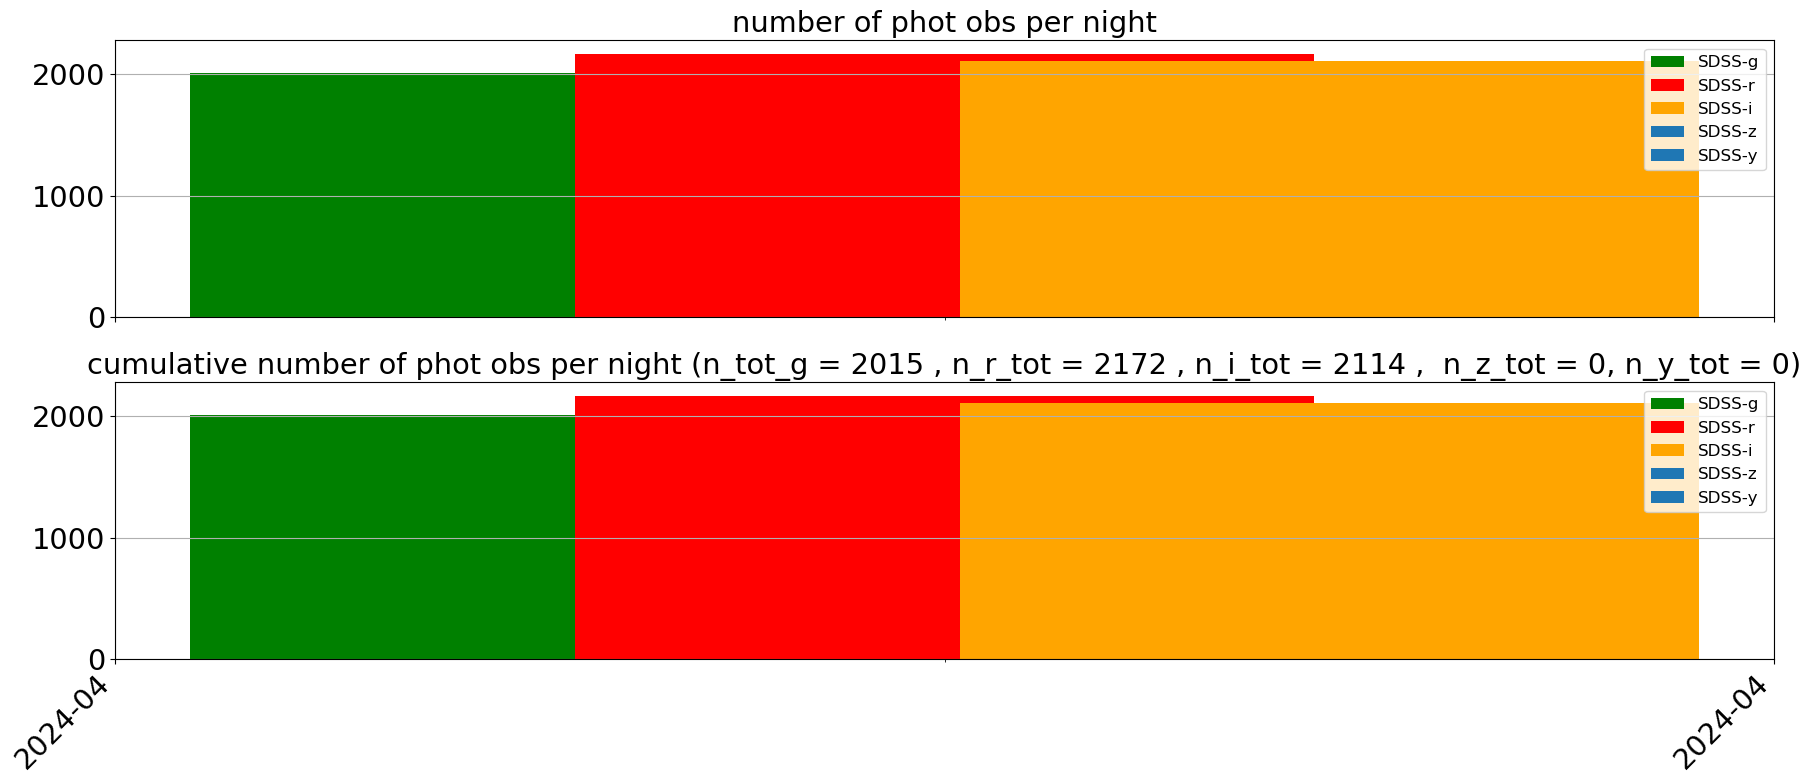

In [63]:
import matplotlib.dates as mdates
month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 
fig, axs = plt.subplots(2,1,figsize=(18, 8),sharex=True)

ax1,ax2 = axs

dt = timedelta(hours=10)

# fit 1
#ax.plot(dt,df_spec_visit.values,marker='o', markersize=15,lw=0)
ax1.bar(dt_g-dt,n_g,lw=5,facecolor='g',label="SDSS-g")
ax1.bar(dt_r,n_r,lw=5,facecolor='r',label="SDSS-r")
ax1.bar(dt_i+dt,n_i,lw=5,facecolor='orange',label="SDSS-i")
ax1.bar(dt_z+2*dt,n_z,lw=5,facecolor='grey',label="SDSS-z")
ax1.bar(dt_y+3*dt,n_y,lw=5,facecolor='k',label="SDSS-y")
ax1.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax1.xaxis.set_minor_locator(day_locator)
ax1.xaxis.set_major_formatter(year_month_formatter)
ax1.grid()
ax1.legend()
ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=45, ha='right')

title = f"number of phot obs per night"
ax1.set_title(title)


ax2.bar(dt_g-dt,s_g,lw=5,facecolor='g',label="SDSS-g")
ax2.bar(dt_r,s_r,lw=5,facecolor='r',label="SDSS-r")
ax2.bar(dt_i+dt,s_i,lw=5,facecolor='orange',label="SDSS-i")
ax2.bar(dt_z+2*dt,s_z,lw=5,facecolor='grey',label="SDSS-z")
ax2.bar(dt_y+3*dt,s_y,lw=5,facecolor='k',label="SDSS-y")
ax2.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax2.xaxis.set_minor_locator(day_locator)
ax2.xaxis.set_major_formatter(year_month_formatter)
ax2.grid()
ax2.legend()
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=45, ha='right')

title = f"cumulative number of phot obs per night (n_tot_g = {n_g_tot} , n_r_tot = {n_r_tot} , n_i_tot = {n_i_tot} ,  n_z_tot = {n_z_tot}, n_y_tot = {n_y_tot})"
ax2.set_title(title)


plt.tight_layout()

## Properties, quality

In [64]:
ccdVisitTable_g = ccd_visit_table[ccd_visit_table.band== "g"]
ccdVisitTable_r = ccd_visit_table[ccd_visit_table.band== "r"]
ccdVisitTable_i = ccd_visit_table[ccd_visit_table.band== "i"]
#ccdVisitTable_z = ccd_visit_table[ccdVisitTable_subset.band== "z"]
#ccdVisitTable_y = ccdVisitTable_subset[ccdVisitTable_subset.band== "y"]

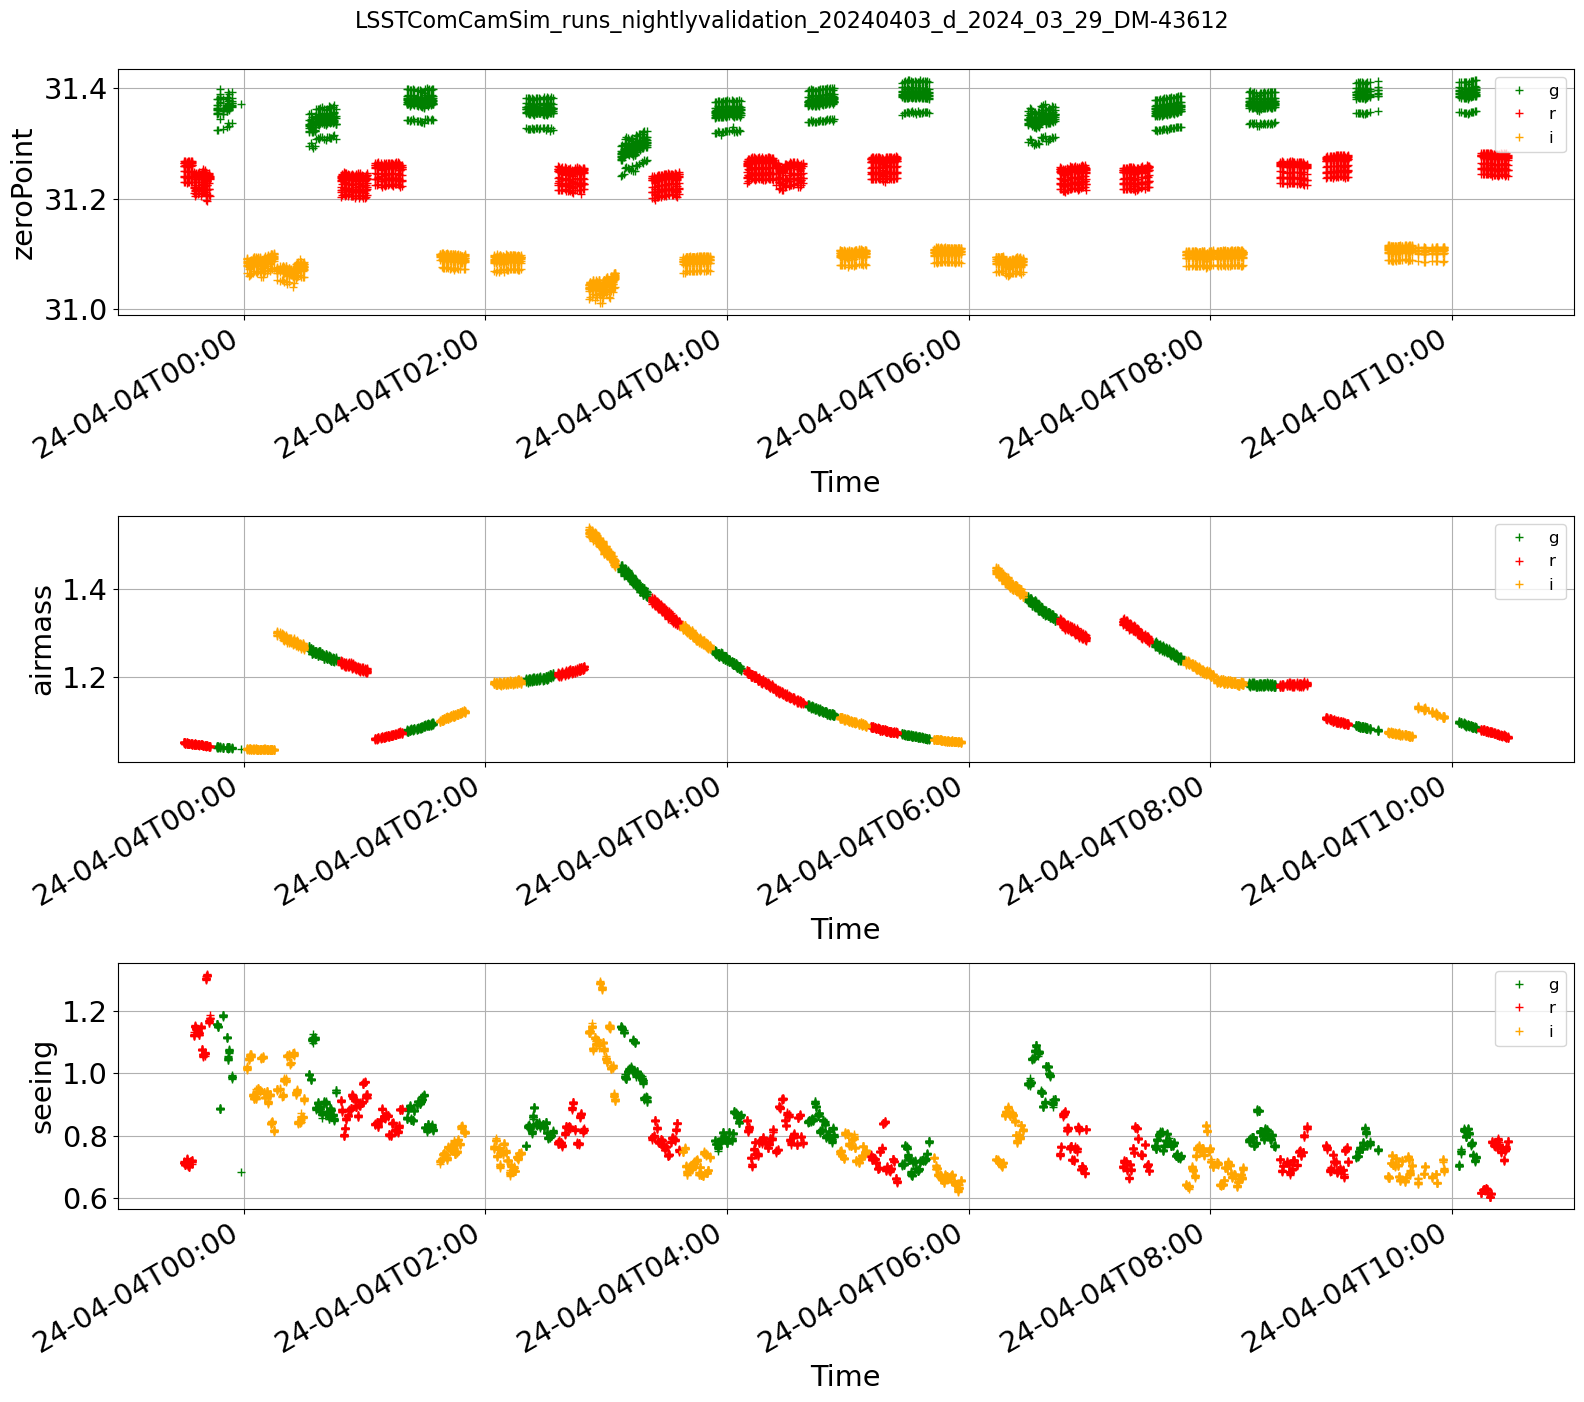

In [65]:
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%dT%H:%M")

fig,axs = plt.subplots(3,1,figsize=(16,14))
ax1,ax2,ax3 = axs
ccdVisitTable_g.plot(x="Time",y="zeroPoint",marker='+',c="g",lw=0.0,ax=ax1,grid=True,label="g")
ccdVisitTable_r.plot(x="Time",y="zeroPoint",marker='+',c="r",lw=0.0,ax=ax1,grid=True,label="r")
ccdVisitTable_i.plot(x="Time",y="zeroPoint",marker='+',c="orange",lw=0.0,ax=ax1,grid=True,label="i")
#ccdVisitTable_z.plot(x="Time",y="zeroPoint",marker='+',c="grey",lw=0.0,ax=ax1,grid=True,label="z")
#ccdVisitTable_g.plot(x="Time",y="zeroPoint",marker='+',c="k",lw=0.0,ax=ax1,grid=True,label="y")
#ax1.set_title("zeroPoint")
ax1.set_ylabel("zeroPoint")
ax1.xaxis.set_major_formatter(date_form)
#ax1_up = ax1.secondary_xaxis("top", functions=( dt_to_mjd, mjd_to_dt))
#ccdVisitTable_g.plot(x="expMidptMJD",y="zeroPoint",marker='+',c="g",lw=0.0,ax=ax1_up,grid=True,label="g")


ccdVisitTable_g.plot(x="Time",y="airmass",marker='+',c="g",lw=0.0,ax=ax2,grid=True,label="g")
ccdVisitTable_r.plot(x="Time",y="airmass",marker='+',c="r",lw=0.0,ax=ax2,grid=True,label="r")
ccdVisitTable_i.plot(x="Time",y="airmass",marker='+',c="orange",lw=0.0,ax=ax2,grid=True,label="i")
#ccdVisitTable_z.plot(x="Time",y="airmass",marker='+',c="grey",lw=0.0,ax=ax2,grid=True,label="z")
#ccdVisitTable_y.plot(x="Time",y="airmass",marker='+',c="k",lw=0.0,ax=ax2,grid=True,label="y")
#ax2.set_title("airmass")
ax2.set_ylabel("airmass")
ax2.xaxis.set_major_formatter(date_form)

ccdVisitTable_g.plot(x="Time",y="seeing",marker='+',c="g",lw=0.0,ax=ax3,grid=True,label="g")
ccdVisitTable_r.plot(x="Time",y="seeing",marker='+',c="r",lw=0.0,ax=ax3,grid=True,label="r")
ccdVisitTable_i.plot(x="Time",y="seeing",marker='+',c="orange",lw=0.0,ax=ax3,grid=True,label="i")
#ccdVisitTable_z.plot(x="Time",y="seeing",marker='+',c="grey",lw=0.0,ax=ax3,grid=True,label="z")
#ccdVisitTable_y.plot(x="Time",y="seeing",marker='+',c="k",lw=0.0,ax=ax3,grid=True,label="y")
#ax2.set_title("airmass")
ax3.set_ylabel("seeing")
ax3.xaxis.set_major_formatter(date_form)

#df.plot(x="Time",y="coord_dec",marker='o',c="g",lw=0.0,ax=ax2,grid=True)
plt.suptitle(suptitle,y=1.0,fontsize=16)
plt.tight_layout()

